In [5]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [6]:
# ====================================
# 1. Reproducibility
# ====================================
def set_seed(seed=42):
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Check if a GPU is available, otherwise, we'll use the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

✅ Using device: cuda


In [7]:
# ====================================
# 2. Dataset and Advanced Augmentations
# ====================================
class MultiClassFaceDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        
        # A simple dictionary to map the deepfake technique names to numbers.
        self.label_map = {
            'Original': 5, 
            'Deepfakes': 0, 
            'Face2Face': 1, 
            'FaceSwap': 3,
            'NeuralTextures': 4,
            'FaceShifter': 2
        }
        # We filter the data to only include the labels we care about.
        self.data = self.data[self.data['label'].isin(self.label_map.keys())].reset_index(drop=True)

    def __len__(self):
        # This tells us the total number of images in our dataset.
        return len(self.data)

    def __getitem__(self, idx):
        # This function loads a single image and its corresponding label and filepath.
        row = self.data.iloc[idx]
        img_path = row['filepath']

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        label = self.label_map[row['label']]
        return img, torch.tensor(label, dtype=torch.long), img_path

def get_dataloaders(csv_path, batch_size=32, img_size=224, num_workers=2):
   
    # These are the transformations for the training images.
    train_tfms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.RandomGrayscale(p=0.1),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3),
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3))
    ])

    # These are for the validation and test sets, which should be consistent.
    test_tfms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    
    full_dataset = MultiClassFaceDataset(csv_file=csv_path, transform=train_tfms)
    total_size = len(full_dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    # We use random_split to divide the dataset into three non-overlapping parts.
    train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

    # The validation and test sets should have deterministic transformations.
    val_data.dataset.transform = test_tfms
    test_data.dataset.transform = test_tfms

    # This part balances the classes in the training data so the model
    # doesn't just learn to predict the most common class.
    labels = [full_dataset.data.iloc[i]['label'] for i in train_data.indices]
    unique_labels, counts = np.unique(labels, return_counts=True)
    class_weights = {label: 1.0 / count for label, count in zip(unique_labels, counts)}
    sample_weights = [class_weights[label] for label in labels]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    train_loader = DataLoader(train_data, batch_size=batch_size, sampler=sampler, num_workers=num_workers)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    print(f"📊 Dataset split -> Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")
    print("Class counts in training set:", {full_dataset.label_map[label_name]: count for label_name, count in zip(unique_labels, counts)})
    
    return train_loader, val_loader, test_loader


In [8]:
# ====================================
# 3. Model (Improved CNN with Residual Connections)
# ====================================
class ResidualBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        # The shortcut is what makes it a 'residual' block. It matches dimensions
        # so we can add the input to the output.
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

class DeepFakeDetectorCNN(nn.Module):
    
    def __init__(self, num_classes=6):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Sequential(
            # Using stride 2 instead of max-pooling to preserve more information
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # We stack our residual blocks to build a deep network.
        self.layer1 = self._make_layer(ResidualBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(ResidualBlock, 512, 2, stride=2)
        # This helps average the features across the image.
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # This is the final layer that makes the predictions.
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.6), # Increased dropout to combat overfitting
            nn.Linear(256, num_classes)
        )

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        # This defines the flow of data through our network.
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [9]:
# ====================================
# 4. Training Loop
# ====================================
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=25, patience=5):
    
    best_val_acc = 0
    patience_counter = 0
    
    # We'll store our performance metrics here to plot them later.
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(epochs):
        print(f"\n🔹 Epoch {epoch+1}/{epochs}")
        model.train() # Set the model to training mode
        train_loss, correct, total = 0, 0, 0
        for imgs, labels, _ in tqdm(train_loader, desc="Training", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            optimizer.step()
            scheduler.step() # Step the scheduler after each batch

            train_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss /= total
        train_acc = correct / total
        
        # Validation - Let's see how well we're doing on unseen data.
        model.eval() # Set the model to evaluation mode
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for imgs, labels, _ in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= total
        val_acc = correct / total
        
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Store our metrics for plotting later
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # We'll save the model that performed best on the validation set.
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            patience_counter = 0
            print("✅ Best model saved!")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("⏹ Early stopping triggered")
                break
    
    return history

In [10]:
# ====================================
# 5. Evaluation & Visualization
# ====================================
def evaluate_model(model, loader, dataset_name="Dataset"):

    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for imgs, labels, _ in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    target_names = ['Original', 'Deepfakes', 'Face2Face', 'FaceSwap', 'NeuralTextures', 'FaceShifter']
    print(f"\n📊 Classification Report for {dataset_name}:")
    print(classification_report(all_labels, all_preds, target_names=target_names, zero_division=0))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=target_names, yticklabels=target_names, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix for {dataset_name}")
    plt.show()

def plot_curves(history):
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def visualize_misclassified_examples(model, loader, num_examples=9):
    
    model.eval()
    misclassified = []
    
    label_map = {
        5: 'Original', 
        0: 'Deepfakes', 
        1: 'Face2Face', 
        3: 'FaceSwap',
        4: 'NeuralTextures',
        2: 'FaceShifter'
    }
    
    with torch.no_grad():
        for imgs, labels, paths in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            
            # Find the images where the prediction does not match the true label.
            misclassified_indices = (preds != labels).nonzero(as_tuple=True)[0]
            
            for idx in misclassified_indices:
                if len(misclassified) < num_examples:
                    img = imgs[idx].cpu().numpy().transpose(1, 2, 0)
                    # Un-normalize the image so it looks correct for plotting.
                    mean = np.array([0.5, 0.5, 0.5])
                    std = np.array([0.5, 0.5, 0.5])
                    img = std * img + mean
                    img = np.clip(img, 0, 1)
                    
                    misclassified.append({
                        'image': img,
                        'true_label': label_map[labels[idx].item()],
                        'predicted_label': label_map[preds[idx].item()],
                        'filepath': paths[idx]
                    })
                else:
                    break
            
            if len(misclassified) >= num_examples:
                break
    
    if len(misclassified) > 0:
        plt.figure(figsize=(10, 10))
        for i, example in enumerate(misclassified):
            plt.subplot(3, 3, i + 1)
            plt.imshow(example['image'])
            plt.title(f"True: {example['true_label']}\nPred: {example['predicted_label']}", fontsize=8)
            plt.axis('off')
        plt.suptitle("Misclassified Examples", fontsize=16)
        plt.tight_layout()
        plt.show()
    else:
        print("🎉 No misclassified examples found. Your model is perfect!")


📊 Dataset split -> Train: 20960, Val: 4491, Test: 4493
Class counts in training set: {0: 3502, 1: 3545, 2: 3451, 3: 3517, 4: 3459, 5: 3486}

--- Starting Model Training ---

🔹 Epoch 1/30


Train Loss: 1.7602 | Train Acc: 0.2179 | Val Loss: 1.7216 | Val Acc: 0.2405
✅ Best model saved!

🔹 Epoch 2/30


Train Loss: 1.5945 | Train Acc: 0.3354 | Val Loss: 1.4900 | Val Acc: 0.3774
✅ Best model saved!

🔹 Epoch 3/30


Train Loss: 1.2476 | Train Acc: 0.5095 | Val Loss: 1.1152 | Val Acc: 0.5444
✅ Best model saved!

🔹 Epoch 4/30


Train Loss: 0.9795 | Train Acc: 0.6365 | Val Loss: 0.9602 | Val Acc: 0.6342
✅ Best model saved!

🔹 Epoch 5/30


Train Loss: 0.8392 | Train Acc: 0.6891 | Val Loss: 0.9930 | Val Acc: 0.6455
✅ Best model saved!

🔹 Epoch 6/30


Train Loss: 0.7496 | Train Acc: 0.7268 | Val Loss: 1.1471 | Val Acc: 0.6181

🔹 Epoch 7/30


Train Loss: 0.6746 | Train Acc: 0.7556 | Val Loss: 0.7811 | Val Acc: 0.7054
✅ Best model saved!

🔹 Epoch 8/30


Train Loss: 0.5908 | Train Acc: 0.7908 | Val Loss: 0.8760 | Val Acc: 0.7136
✅ Best model saved!

🔹 Epoch 9/30


Train Loss: 0.5147 | Train Acc: 0.8232 | Val Loss: 1.0036 | Val Acc: 0.6898

🔹 Epoch 10/30


Train Loss: 0.4524 | Train Acc: 0.8421 | Val Loss: 0.6029 | Val Acc: 0.7825
✅ Best model saved!

🔹 Epoch 11/30


Train Loss: 0.3890 | Train Acc: 0.8685 | Val Loss: 0.4675 | Val Acc: 0.8312
✅ Best model saved!

🔹 Epoch 12/30


Train Loss: 0.3316 | Train Acc: 0.8870 | Val Loss: 0.4876 | Val Acc: 0.8426
✅ Best model saved!

🔹 Epoch 13/30


Train Loss: 0.2894 | Train Acc: 0.9018 | Val Loss: 0.4682 | Val Acc: 0.8459
✅ Best model saved!

🔹 Epoch 14/30


Train Loss: 0.2469 | Train Acc: 0.9160 | Val Loss: 0.5133 | Val Acc: 0.8470
✅ Best model saved!

🔹 Epoch 15/30


Train Loss: 0.2047 | Train Acc: 0.9333 | Val Loss: 0.4005 | Val Acc: 0.8755
✅ Best model saved!

🔹 Epoch 16/30


Train Loss: 0.1698 | Train Acc: 0.9450 | Val Loss: 0.4487 | Val Acc: 0.8673

🔹 Epoch 17/30


Train Loss: 0.1462 | Train Acc: 0.9554 | Val Loss: 0.4756 | Val Acc: 0.8631

🔹 Epoch 18/30


Train Loss: 0.1146 | Train Acc: 0.9645 | Val Loss: 0.5396 | Val Acc: 0.8637

🔹 Epoch 19/30


Train Loss: 0.0974 | Train Acc: 0.9690 | Val Loss: 0.4841 | Val Acc: 0.8737

🔹 Epoch 20/30


Train Loss: 0.0720 | Train Acc: 0.9771 | Val Loss: 0.5486 | Val Acc: 0.8622

🔹 Epoch 21/30


Train Loss: 0.0489 | Train Acc: 0.9855 | Val Loss: 0.5013 | Val Acc: 0.8869
✅ Best model saved!

🔹 Epoch 22/30


Train Loss: 0.0404 | Train Acc: 0.9878 | Val Loss: 0.4702 | Val Acc: 0.8980
✅ Best model saved!

🔹 Epoch 23/30


Train Loss: 0.0296 | Train Acc: 0.9912 | Val Loss: 0.4851 | Val Acc: 0.8956

🔹 Epoch 24/30


Train Loss: 0.0185 | Train Acc: 0.9945 | Val Loss: 0.4955 | Val Acc: 0.9002
✅ Best model saved!

🔹 Epoch 25/30


Train Loss: 0.0150 | Train Acc: 0.9955 | Val Loss: 0.5334 | Val Acc: 0.8991

🔹 Epoch 26/30


Train Loss: 0.0122 | Train Acc: 0.9963 | Val Loss: 0.4924 | Val Acc: 0.9007
✅ Best model saved!

🔹 Epoch 27/30


Train Loss: 0.0063 | Train Acc: 0.9987 | Val Loss: 0.5281 | Val Acc: 0.9047
✅ Best model saved!

🔹 Epoch 28/30


Train Loss: 0.0068 | Train Acc: 0.9982 | Val Loss: 0.5114 | Val Acc: 0.9045

🔹 Epoch 29/30


Train Loss: 0.0049 | Train Acc: 0.9988 | Val Loss: 0.5134 | Val Acc: 0.9074
✅ Best model saved!

🔹 Epoch 30/30


Train Loss: 0.0045 | Train Acc: 0.9988 | Val Loss: 0.5116 | Val Acc: 0.9054

--- Evaluation on Training Set ---

📊 Classification Report for Training Set:
                precision    recall  f1-score   support

      Original       1.00      1.00      1.00      3495
     Deepfakes       1.00      1.00      1.00      3529
     Face2Face       1.00      1.00      1.00      3443
      FaceSwap       1.00      1.00      1.00      3477
NeuralTextures       1.00      1.00      1.00      3493
   FaceShifter       1.00      1.00      1.00      3523

      accuracy                           1.00     20960
     macro avg       1.00      1.00      1.00     20960
  weighted avg       1.00      1.00      1.00     20960



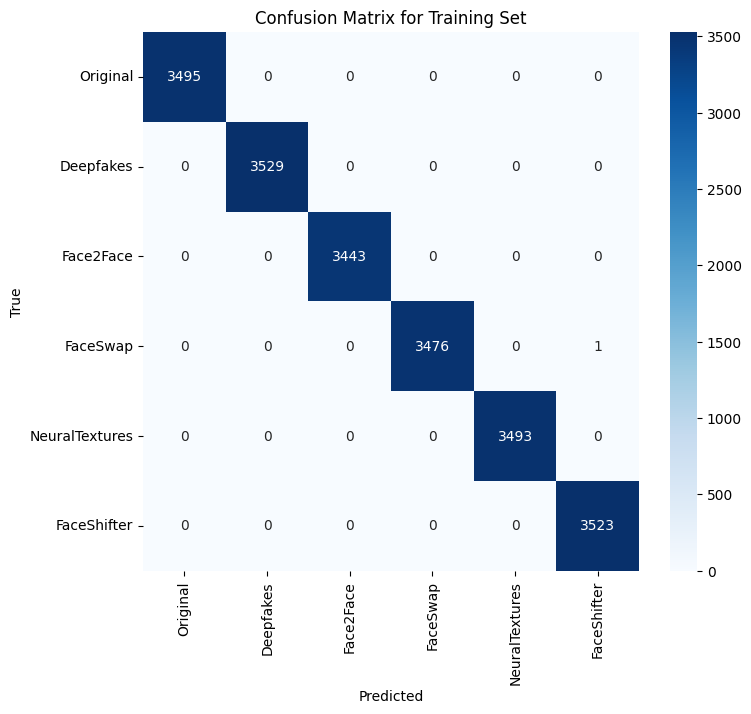


--- Evaluation on Validation Set ---

📊 Classification Report for Validation Set:
                precision    recall  f1-score   support

      Original       0.96      0.97      0.97       732
     Deepfakes       0.97      0.95      0.96       721
     Face2Face       0.96      0.94      0.95       751
      FaceSwap       0.96      0.94      0.95       741
NeuralTextures       0.85      0.83      0.84       776
   FaceShifter       0.76      0.82      0.79       770

      accuracy                           0.91      4491
     macro avg       0.91      0.91      0.91      4491
  weighted avg       0.91      0.91      0.91      4491



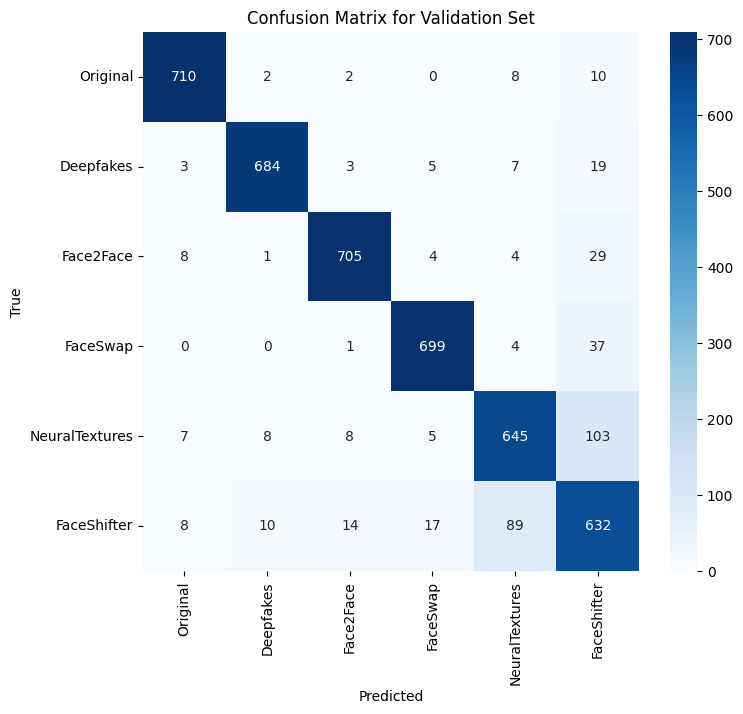


--- Final Evaluation on Test Set ---

📊 Classification Report for Test Set:
                precision    recall  f1-score   support

      Original       0.97      0.95      0.96       736
     Deepfakes       0.98      0.95      0.97       734
     Face2Face       0.97      0.96      0.96       790
      FaceSwap       0.96      0.95      0.96       736
NeuralTextures       0.83      0.82      0.83       760
   FaceShifter       0.74      0.81      0.77       737

      accuracy                           0.91      4493
     macro avg       0.91      0.91      0.91      4493
  weighted avg       0.91      0.91      0.91      4493



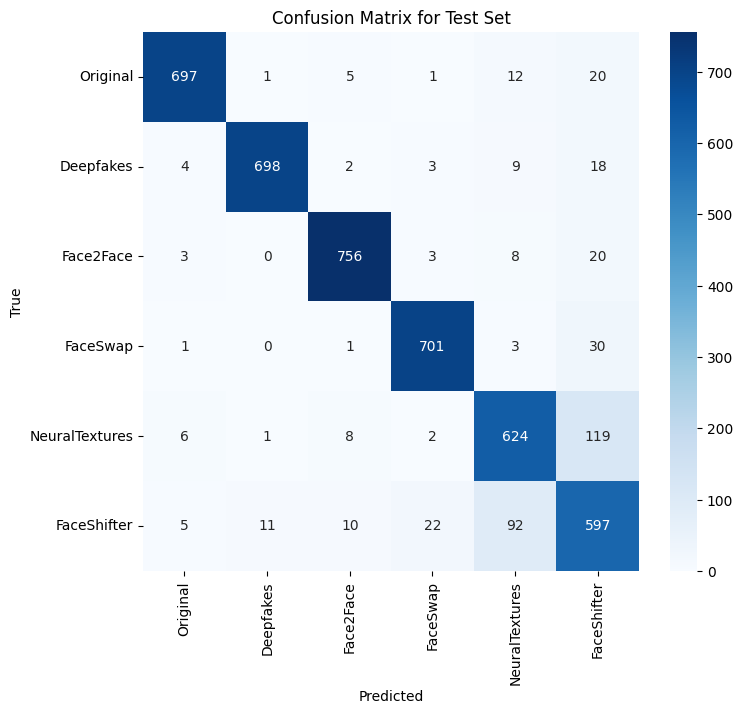


--- Visualizing Training & Validation Curves ---


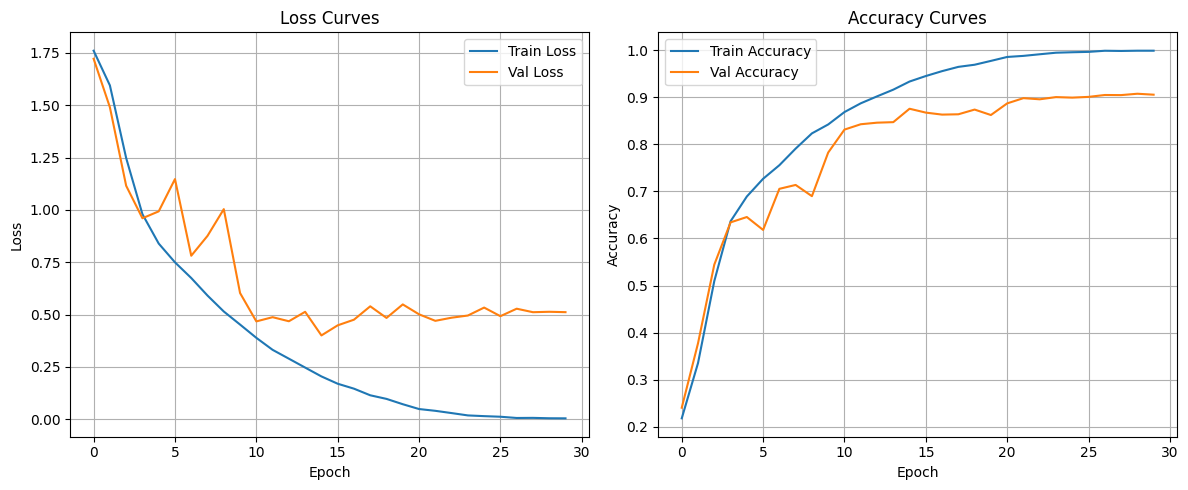


--- Visualizing Misclassified Examples ---


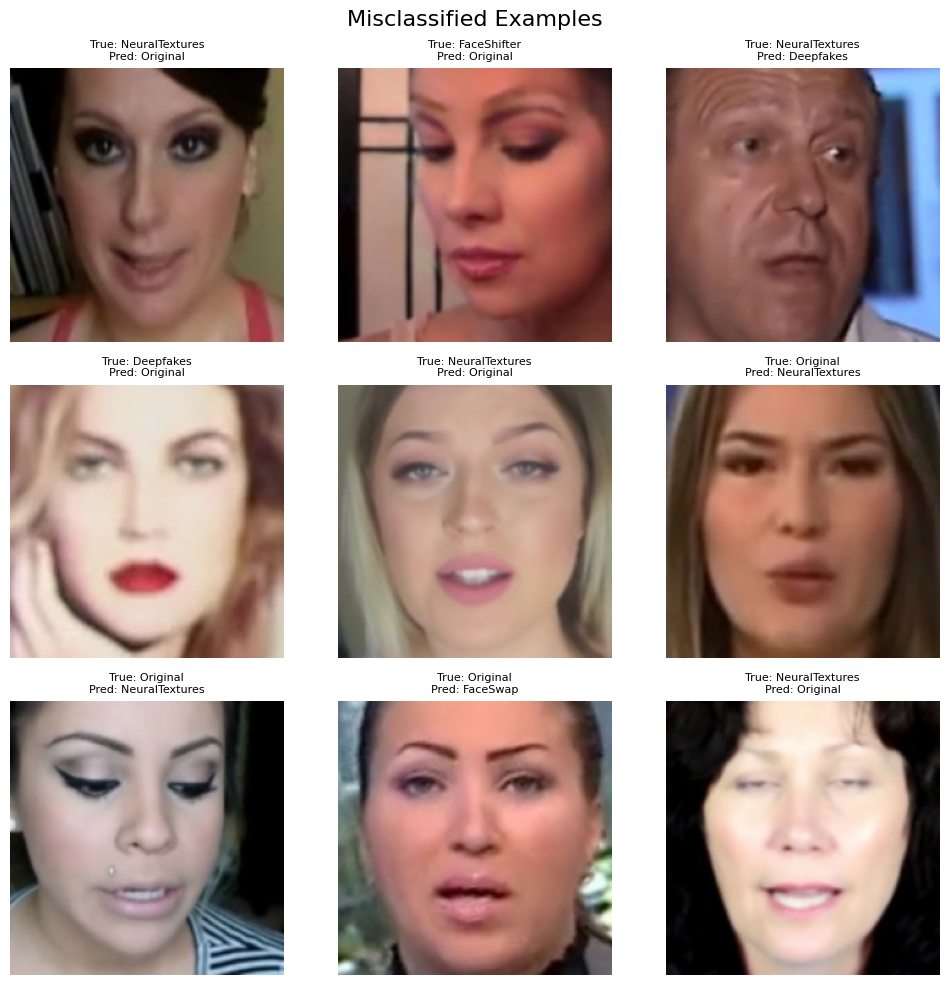

In [11]:
# ====================================
# 6. Main Execution Block
# ====================================
if __name__ == "__main__":
    csv_path = "/kaggle/input/faceforensics-c32-frames-cropped-aligned/Frames(Crop+Align).csv"
    if not os.path.exists(csv_path):
        print(f"Error: The CSV file at {csv_path} was not found.")
    else:
        # Step 1: Prepare the data loaders
        train_loader, val_loader, test_loader = get_dataloaders(csv_path, batch_size=32, img_size=224)

        # Step 2: Initialize the model, loss function, optimizer, and scheduler
        model = DeepFakeDetectorCNN(num_classes=6).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                                    max_lr=1e-3,
                                                    steps_per_epoch=len(train_loader),
                                                    epochs=30,
                                                    pct_start=0.3,
                                                    div_factor=10,
                                                    final_div_factor=100)

        # Step 3: Train the model and get the training history
        print("\n--- Starting Model Training ---")
        history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=30, patience=7)
        
        # Step 4: Load the best model weights
        model.load_state_dict(torch.load("best_model.pth"))
        
        # Step 5: Generate classification reports for all three datasets
        print("\n--- Evaluation on Training Set ---")
        evaluate_model(model, train_loader, dataset_name="Training Set")
        
        print("\n--- Evaluation on Validation Set ---")
        evaluate_model(model, val_loader, dataset_name="Validation Set")

        print("\n--- Final Evaluation on Test Set ---")
        evaluate_model(model, test_loader, dataset_name="Test Set")

        # Step 6: Visualize the training progress and misclassified images
        print("\n--- Visualizing Training & Validation Curves ---")
        plot_curves(history)

        print("\n--- Visualizing Misclassified Examples ---")
        visualize_misclassified_examples(model, test_loader, num_examples=9)


✅ Successfully loaded trained model weights.


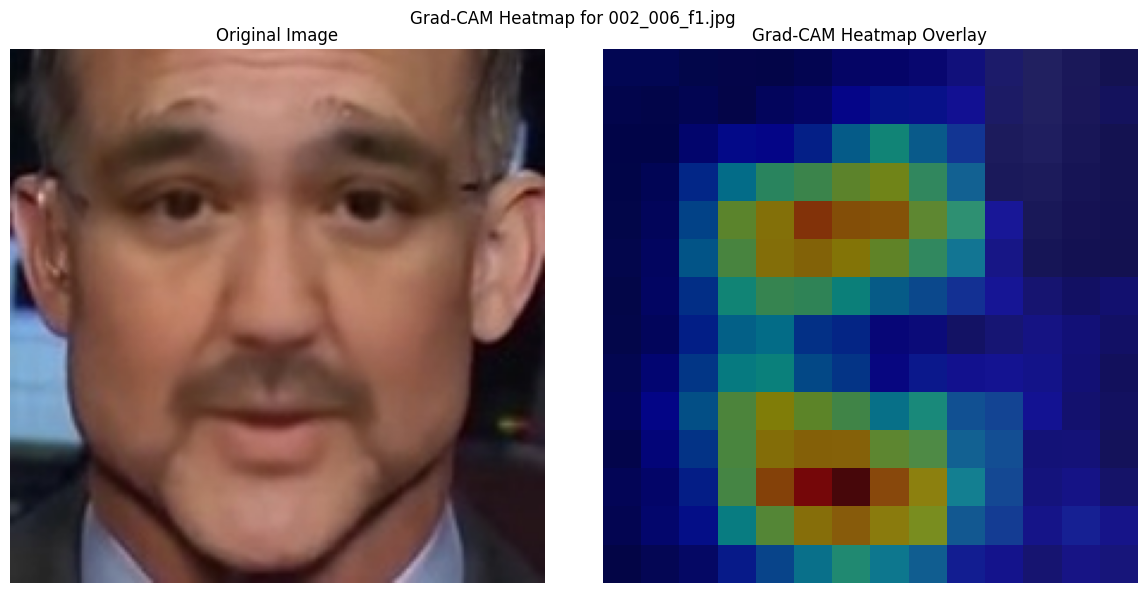

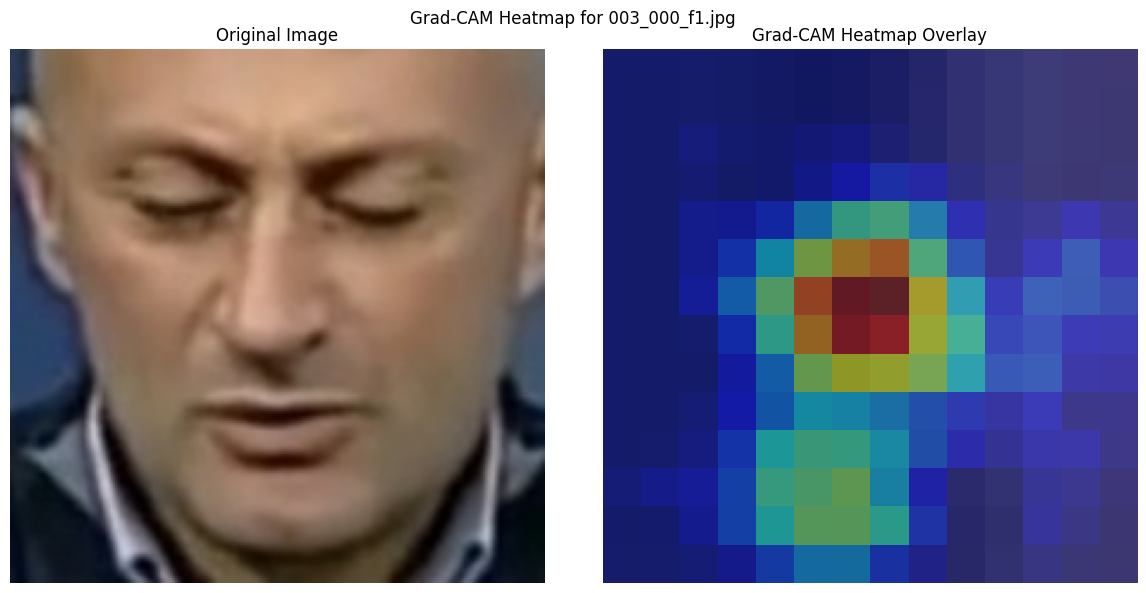

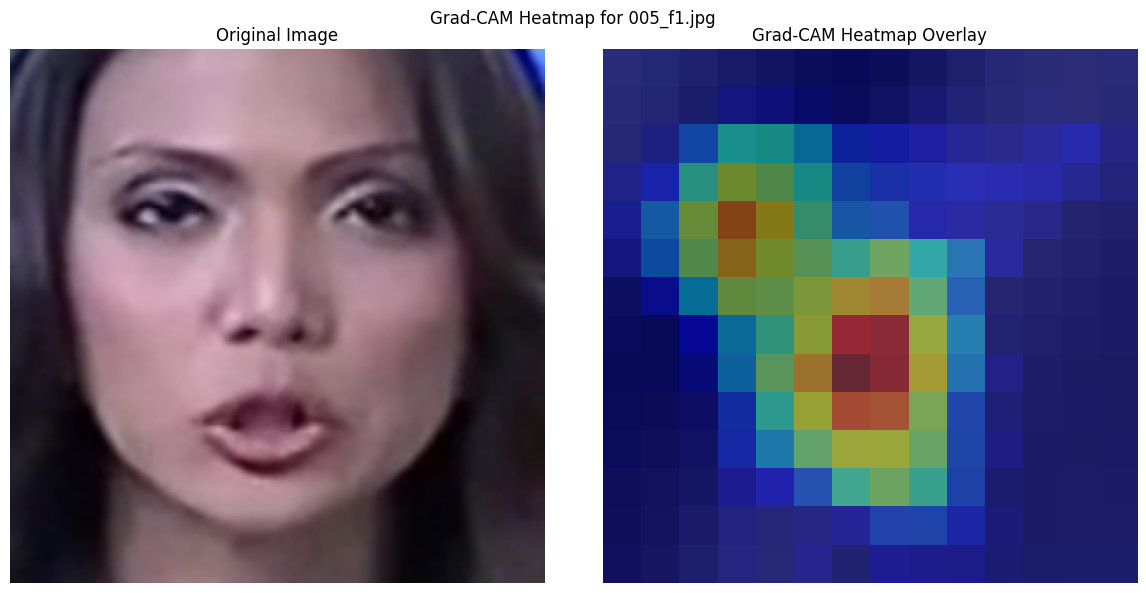

In [13]:
# ============= GRAD CAM ==================

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns


class ResidualBlock(nn.Module):
    """A building block for our model."""
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

class DeepFakeDetectorCNN(nn.Module):
    """The main CNN architecture for deepfake detection."""
    def __init__(self, num_classes=6):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer1 = self._make_layer(ResidualBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(ResidualBlock, 512, 2, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(256, num_classes)
        )

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def grad_cam(model, target_layer, input_tensor):
    
    # 1. Get the feature maps and gradients
    model.eval()
    
    # Store feature maps and gradients in global variables
    features = None
    gradients = None
    
    def forward_hook(module, input, output):
        nonlocal features
        features = output
    
    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]
        
    hook_handle_forward = target_layer.register_forward_hook(forward_hook)
    hook_handle_backward = target_layer.register_full_backward_hook(backward_hook)
    
    # Forward pass
    output = model(input_tensor)
    pred_class = torch.argmax(output, dim=1)
    
    # Backward pass
    model.zero_grad()
    one_hot_output = torch.zeros_like(output).scatter_(1, pred_class.unsqueeze(1), 1)
    output.backward(gradient=one_hot_output)
    
    # Remove hooks
    hook_handle_forward.remove()
    hook_handle_backward.remove()
    
    # 2. Pool the gradients and create the heatmap
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    
    for i in range(features.shape[1]):
        features[:, i, :, :] *= pooled_gradients[i]
        
    heatmap = torch.mean(features, dim=1).squeeze()
    
    # ReLU to keep only positive gradients (what contributes to the class)
    heatmap = F.relu(heatmap)
    
    # Normalize the heatmap to be between 0 and 1
    heatmap /= torch.max(heatmap)
    
    return heatmap

def visualize_grad_cam(model, image_path, target_layer, img_size=224):
    
    # Define the transformations for the image
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    
    # Load and preprocess the image
    try:
        original_image = Image.open(image_path).convert("RGB")
        input_tensor = transform(original_image).unsqueeze(0).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
        return
        
    # Generate the heatmap
    heatmap = grad_cam(model, target_layer, input_tensor)
    
    # Convert heatmap to a numpy array for visualization
    heatmap = heatmap.detach().cpu().numpy()
    
    # Get the original image as a numpy array
    img_np = np.array(original_image.resize((img_size, img_size)))
    
    # Plot the original image and the heatmap
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Grad-CAM Heatmap for {os.path.basename(image_path)}")
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_np)
    plt.imshow(heatmap, cmap='jet', alpha=0.5, interpolation='nearest')
    plt.title("Grad-CAM Heatmap Overlay")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# --- Main Execution Block ---
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DeepFakeDetectorCNN(num_classes=6).to(device)
    
    # Load the trained model weights
    try:
        model.load_state_dict(torch.load("best_model.pth"))
        print("✅ Successfully loaded trained model weights.")
    except FileNotFoundError:
        print("Error: 'best_model.pth' not found. Please train the model first.")
        # Exit if the model file is not found
        exit()

    # Define the target layer for visualization. 
    # A good choice is usually the last convolutional layer.
    target_layer = model.layer4 

    # List of images to analyze.
    # Replace these paths with the ones from your dataset.
    image_paths_to_analyze = [
        "/kaggle/input/faceforensics-c32-frames-cropped-aligned/Frames(cropped+aligned)/Deepfakes/002_006_f1.jpg",
        "/kaggle/input/faceforensics-c32-frames-cropped-aligned/Frames(cropped+aligned)/NeuralTextures/003_000_f1.jpg",
        "/kaggle/input/faceforensics-c32-frames-cropped-aligned/Frames(cropped+aligned)/Original/005_f1.jpg"
    ]
    
    # Loop through the list and visualize each image
    for path in image_paths_to_analyze:
        if os.path.exists(path):
            visualize_grad_cam(model, path, target_layer)
        else:
            print(f"Skipping visualization for {path} as it does not exist.")
